# From DMRG Ground States to Quantum Circuits
## Compiling Physics-Relevant States

In the previous notebooks we compiled synthetic states (GHZ, random MPS). In practice, the most important use case is compiling **physically relevant** quantum states — ground states of many-body Hamiltonians found via classical algorithms like DMRG.

In this notebook you will:
1. Use DMRG (via ITensors.jl) to find ground states of the transverse-field Ising model
2. Convert ITensor MPS to TenSynth format with `from_itensors()`
3. Study entanglement across the quantum phase transition
4. Compile ground states into quantum circuits and see how circuit depth depends on the phase
5. Build a custom MPS (Bell pair) from scratch
6. Export circuits to OpenQASM

## The Transverse-Field Ising Model (TFIM)

The 1D TFIM is one of the simplest models with a quantum phase transition:

$$H = -J \sum_{i} Z_i Z_{i+1} - h \sum_i X_i$$

Three regimes (setting $J=1$):
- **Ordered phase** ($h/J < 1$): Ground state is a superposition of $Z$-aligned configurations, with moderate entanglement
- **Critical point** ($h/J = 1$): Quantum phase transition, algebraically decaying correlations, **logarithmic** entanglement scaling — the most entangled phase
- **Disordered phase** ($h/J > 1$): Spins align along $X$, ground state is nearly a product state, very low entanglement

The critical state is the hardest to compile because it has the most entanglement.

## Setup

In [1]:
using Pkg
Pkg.activate(joinpath(@__DIR__, ".."))

using TenSynth
using TenSynth.Core
using TenSynth.MPS
using TenSynth.MPS: from_itensors, bond_dimensions, entanglement_entropy, wMPS

# Explicitly import inner from TenSynth.MPS to avoid conflict with ITensors.inner
import TenSynth.MPS: inner as tensynth_inner

using ITensors
using ITensorMPS
using LinearAlgebra
using Random
using Plots
gr()

Random.seed!(42)
println("All packages loaded.")

  Activating project at `~/Documents/Programming/PhD/ClaudeCodeExperiments/TenSynth_Master/TenSynthRepo/TenSynth`


All packages loaded.


## 1. DMRG Ground States

We define a helper function to run DMRG for the TFIM using ITensors. The Hamiltonian uses `Sz` and `Sx` operators (which are $Z/2$ and $X/2$ for spin-1/2), so we multiply by appropriate factors.

In [2]:
function dmrg_tfim(N::Int, J::Float64, h::Float64; maxdim::Int=64, nsweeps::Int=10)
    sites = siteinds("S=1/2", N)

    # Build H = -J Σ ZZ - h Σ X using Sz = Z/2, Sx = X/2
    os = OpSum()
    for j in 1:N-1
        os += -4.0 * J, "Sz", j, "Sz", j+1
    end
    for j in 1:N
        os += -2.0 * h, "Sx", j
    end
    H = MPO(os, sites)

    psi0 = random_mps(sites; linkdims=4)
    dims = vcat([10], [min(2^k, maxdim) for k in 2:nsweeps])
    energy, psi = dmrg(H, psi0;
        nsweeps=nsweeps,
        maxdim=dims[1:nsweeps],
        cutoff=1e-10,
        outputlevel=0
    )
    return energy, psi, sites
end

println("DMRG helper defined.")

DMRG helper defined.


In [3]:
N = 20
J = 1.0

# Three phases of the TFIM
phases = [
    ("Ordered (h=0.5)",    0.5),
    ("Critical (h=1.0)",   1.0),
    ("Disordered (h=3.0)", 3.0),
]

dmrg_results = Dict{String, Any}()
for (label, h) in phases
    Random.seed!(42)
    energy, psi, sites = dmrg_tfim(N, J, h; maxdim=64, nsweeps=10)
    dmrg_results[label] = (energy=energy, psi=psi, sites=sites, h=h)
    println("$label:  E = $(round(energy, digits=6)),  E/N = $(round(energy/N, digits=6))")
end

Ordered (h=0.5):  E = -20.400217,  E/N = -1.020011
Critical (h=1.0):  E = -25.107797,  E/N = -1.25539
Disordered (h=3.0):  E = -61.593422,  E/N = -3.079671


## 2. Converting to TenSynth Format

The `from_itensors()` function converts an ITensors MPS into TenSynth's `FiniteMPS{ComplexF64}` format.

In [4]:
mps_states = Dict{String, FiniteMPS{ComplexF64}}()

for (label, h) in phases
    psi = dmrg_results[label].psi
    mps = from_itensors(psi)
    mps_states[label] = mps
    println("$label:")
    println("  Bond dimensions: $(bond_dimensions(mps))")
    println("  Max bond dim:    $(max_bond_dim(mps))")
    println()
end

Ordered (h=0.5):
  Bond dimensions: [2, 4, 5, 5, 5, 4, 4, 3, 3, 3, 3, 4, 4, 4, 5, 5, 5, 4, 2]
  Max bond dim:    5

Critical (h=1.0):
  Bond dimensions: [2, 4, 7, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 7, 4, 2]
  Max bond dim:    10

Disordered (h=3.0):
  Bond dimensions: [2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2]
  Max bond dim:    4



## 3. Entanglement Across the Phase Transition

The entanglement entropy profile reveals the physics of each phase:
- **Critical**: Highest entanglement — logarithmic scaling $S \sim \frac{c}{3}\log(\ell)$ with central charge $c=1/2$
- **Disordered**: Low entanglement — nearly a product state in the $X$ basis
- **Ordered**: Very low entanglement — deep in the ordered phase, the ground state is close to a product state in the $Z$ basis

In [5]:
sites_range = 1:(N-1)
entropy_profiles = Dict{String, Vector{Float64}}()

for (label, _) in phases
    mps = mps_states[label]
    S = [entanglement_entropy(mps, k) for k in sites_range]
    entropy_profiles[label] = S
    println("$label:  max S = $(round(maximum(S), digits=4))")
end

Ordered (h=0.5):  max S = 0.026
Critical (h=1.0):  max S = 0.4438
Disordered (h=3.0):  max S = 0.0432


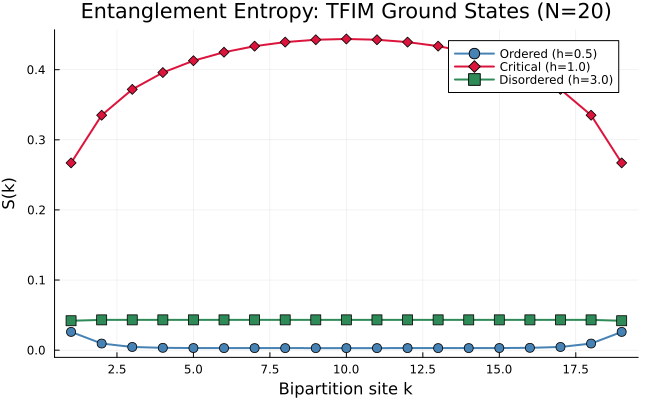

In [6]:
p = plot(title="Entanglement Entropy: TFIM Ground States (N=$N)",
         xlabel="Bipartition site k", ylabel="S(k)",
         legend=:topright, size=(650, 400))

colors = [:steelblue, :crimson, :seagreen]
markers = [:circle, :diamond, :square]
for (i, (label, _)) in enumerate(phases)
    plot!(p, collect(sites_range), entropy_profiles[label],
          label=label, marker=markers[i], linewidth=2,
          markersize=5, color=colors[i])
end

p

The **critical** state (red) has the highest entanglement — this is a hallmark of quantum criticality. The entropy peaks in the bulk of the chain, following the conformal field theory prediction $S \sim \frac{c}{3}\log\bigl(\frac{N}{\pi}\sin\frac{\pi \ell}{N}\bigr)$. Both the **ordered** (blue) and **disordered** (green) phases have very low entanglement, as their ground states are close to product states in the $Z$ and $X$ bases respectively.

## 4. Compiling Ground States into Circuits

Now we compile each ground state into a quantum circuit at increasing depths and compare how fidelity scales across the three phases.

In [7]:
depths = [2, 4, 6, 8]
compilation_data = Dict{String, Vector{Float64}}()

for (label, _) in phases
    mps = mps_states[label]
    fids = Float64[]
    for d in depths
        result = decompose(mps;
            method=:iterative,
            max_layers=d,
            n_sweeps=20,
            target_fidelity=1.0,
            verbose=false
        )
        push!(fids, result.fidelity)
    end
    compilation_data[label] = fids
    println("$label:")
    for (d, f) in zip(depths, fids)
        println("  depth $d → fidelity $(round(f, digits=6))")
    end
    println()
end

Ordered (h=0.5):
  depth 2 → fidelity 0.999876
  depth 4 → fidelity 0.999996
  depth 6 → fidelity 0.999999
  depth 8 → fidelity 1.0

Critical (h=1.0):
  depth 2 → fidelity 0.595779
  depth 4 → fidelity 0.84846
  depth 6 → fidelity 0.927711
  depth 8 → fidelity 0.972929

Disordered (h=3.0):
  depth 2 → fidelity 0.996738
  depth 4 → fidelity 0.999891
  depth 6 → fidelity 0.999989
  depth 8 → fidelity 1.0



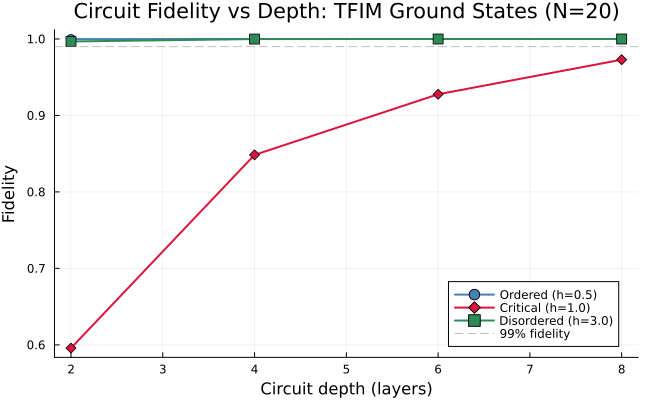

In [8]:
p = plot(title="Circuit Fidelity vs Depth: TFIM Ground States (N=$N)",
         xlabel="Circuit depth (layers)", ylabel="Fidelity",
         legend=:bottomright, size=(650, 400))

colors = [:steelblue, :crimson, :seagreen]
markers = [:circle, :diamond, :square]
for (i, (label, _)) in enumerate(phases)
    plot!(p, depths, compilation_data[label],
          label=label, marker=markers[i], linewidth=2,
          markersize=5, color=colors[i])
end

hline!(p, [0.99], linestyle=:dash, color=:gray, alpha=0.5, label="99% fidelity")

p

The results match the entanglement structure:
- The **ordered** and **disordered** phases (low entanglement) both reach high fidelity at shallow depth
- The **critical** phase (highest entanglement) requires significantly deeper circuits and still hasn't reached 99% at depth 8

This confirms the connection between entanglement structure and circuit complexity established in Notebook 02.

## 5. Full Compilation Pipeline

Let's run the full `compile()` pipeline on the ordered-phase ground state, including circuit statistics.

In [9]:
result_ordered = compile(mps_states["Ordered (h=0.5)"];
    method=:iterative,
    max_layers=6,
    n_sweeps=20,
    synthesize_gates=false,
    verbose=false
)

result_ordered

CompilationResult:
  Qubits:            20
  Fidelity:          0.99987617
  Circuit depth:     2 layers
  2-qubit gates:     19
  Method:            :iterative
  Synthesis:         not performed
  Elapsed time:      0.219 seconds


In [10]:
stats = circuit_stats(result_ordered)
for (k, v) in pairs(stats)
    println("  $k = $v")
end

  n_qubits = 20
  circuit_depth = 2
  n_2q_gates = 19
  n_rz_rotations = 285
  n_t_gates = 0
  n_clifford_gates = 0
  fidelity = 0.9998761749370866
  synthesis_error = 0.0


In [11]:
println(show_circuit(result_ordered))

q0: ----*-
         | 
q1: -*--*-
      |    
q2: -*--*-
         | 
q3: -*--*-
      |    
q4: -*--*-
         | 
q5: -*--*-
      |    
q6: -*--*-
         | 
q7: -*--*-
      |    
q8: -*--*-
         | 
q9: -*--*-
      |    
q10: -*--*-
         | 
q11: -*--*-
      |    
q12: -*--*-
         | 
q13: -*--*-
      |    
q14: -*--*-
         | 
q15: -*--*-
      |    
q16: -*--*-
         | 
q17: -*--*-
      |    
q18: -*--*-
         | 
q19: ----*-


## 6. Building a Custom MPS: Bell Pair

You can also build MPS from scratch using the `FiniteMPS` constructor. Each tensor has shape `[left_bond, physical, right_bond]` where the physical dimension is 2 (for qubits).

Let's construct the Bell state $|\Phi^+\rangle = (|00\rangle + |11\rangle)/\sqrt{2}$:

In [12]:
# Bell state: (|00⟩ + |11⟩)/√2
# Tensor shapes: [left_bond, physical, right_bond]
A1 = zeros(ComplexF64, 1, 2, 2)
A1[1, 1, 1] = 1/√2   # |0⟩ → bond index 1
A1[1, 2, 2] = 1/√2   # |1⟩ → bond index 2

A2 = zeros(ComplexF64, 2, 2, 1)
A2[1, 1, 1] = 1.0     # bond index 1 → |0⟩
A2[2, 2, 1] = 1.0     # bond index 2 → |1⟩

bell_mps = FiniteMPS{ComplexF64}([A1, A2])

println("Bell state MPS:")
println("  Bond dimensions: $(bond_dimensions(bell_mps))")
println("  Entanglement entropy: $(round(entanglement_entropy(bell_mps, 1), digits=4))")
println("  Self-fidelity: $(round(fidelity(bell_mps, bell_mps), digits=10))")

# Compare with GHZ(2) which is also a Bell state
ghz2 = ghzMPS(2)
println("  Fidelity vs ghzMPS(2): $(round(fidelity(bell_mps, ghz2), digits=10))")

# Compile it
result_bell = compile(bell_mps;
    method=:analytical,
    synthesize_gates=false,
    verbose=false
)
println("  Compiled fidelity: $(round(result_bell.fidelity, digits=10))")

Bell state MPS:
  Bond dimensions: [2]
  Entanglement entropy: 0.6931
  Self-fidelity: 1.0
  Fidelity vs ghzMPS(2): 1.0
  Compiled fidelity: 1.0


## 7. Export to OpenQASM

Finally, let's export the ordered-phase circuit to OpenQASM format.

In [13]:
qasm = to_openqasm(result_ordered)
qasm_lines = split(qasm, '\n')
for line in qasm_lines[1:min(25, length(qasm_lines))]
    println(line)
end
if length(qasm_lines) > 25
    println("... ($(length(qasm_lines) - 25) more lines)")
end

OPENQASM 2.0;
include "qelib1.inc";

// TenSynth compilation result
// Fidelity: 0.99987617
// Method: iterative

qreg q[20];

// Layer 1
h q[2];
rz(-3.5862838353753625) q[2];
h q[2];
rz(-3.0438040914691857) q[2];
h q[2];
rz(1.1602521120354377) q[2];
h q[2];
h q[1];
rz(-1.5693968169083103) q[1];
h q[1];
rz(-1.5719960672753275) q[1];
h q[1];
rz(1.6020135791746892) q[1];
h q[1];
h q[1];
... (751 more lines)


## Summary

In this notebook you learned:

- How to find ground states via **DMRG** using ITensors.jl
- How to convert ITensor MPS to TenSynth format with `from_itensors()`
- That **entanglement structure** across a phase transition directly controls circuit depth:
  - Disordered phase (low entanglement) → shallow circuits
  - Critical point (highest entanglement) → deepest circuits
  - Ordered phase → intermediate depth
- How to build custom MPS from raw tensors using the `FiniteMPS{ComplexF64}` constructor
- How to export compiled circuits to **OpenQASM**

**Key functions used:**
- `from_itensors(psi)` — convert ITensor MPS to TenSynth FiniteMPS
- `FiniteMPS{ComplexF64}([A1, A2, ...])` — build MPS from raw tensors
- `entanglement_entropy(mps, site)` — entropy at a bipartition
- `compile(mps; ...)` — full compilation pipeline
- `decompose(mps; ...)` — decompose MPS into circuit at specific depth
- `to_openqasm(result)` — export to OpenQASM 2.0

**Next**: Notebook 04 moves from state preparation to **unitary compilation** using MPOs.